In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/09/14 15:35:13 WARN Utils: Your hostname, Xiaotongs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.3.32 instead (on interface en0)
22/09/14 15:35:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/14 15:35:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/14 15:35:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
sdf = spark.read.parquet("../data/curated/full_data/")
merchant_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")
consumer_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")

<AxesSubplot:xlabel='fraud_probability', ylabel='Count'>

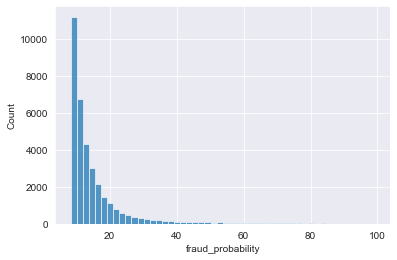

In [5]:
sns.histplot(consumer_df["fraud_probability"], bins=50)

<AxesSubplot:xlabel='fraud_probability', ylabel='Count'>

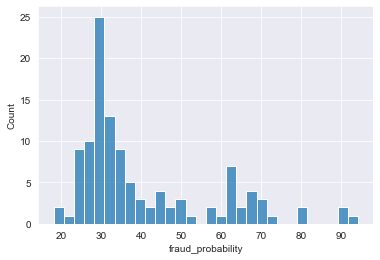

In [6]:
sns.histplot(merchant_df["fraud_probability"], bins=30)

In [34]:
# sorted(consumer_df["order_datetime"].unique())
# data from 2021-02-28 to 2022-02-27

In [16]:
transactions = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')\
    .union(spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot'))

In [17]:
transactions_by_merch_date = transactions.groupBy('merchant_abn', 'order_datetime').sum('dollar_value')

In [18]:
probs = spark.read.option('header', True).csv('../data/tables/merchant_fraud_probability.csv')

In [19]:
probs = probs.withColumn('merchant_abn', F.col('merchant_abn').cast('long'))\
        .withColumn('order_datetime', F.col('order_datetime').cast('date'))\
        .withColumn('fraud_probability', F.col('fraud_probability').cast('float'))

In [20]:
probs.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- fraud_probability: float (nullable = true)



In [21]:
merchant_with_probs = transactions_by_merch_date.join(probs, on=['merchant_abn','order_datetime'], how='left')

In [22]:
merchant_with_probs = merchant_with_probs.na.fill(0)

In [23]:
merchant_with_probs = merchant_with_probs.withColumn('expected_dollar_value', (F.col('sum(dollar_value)')*(1-F.col('fraud_probability')/100)))

In [24]:
merchant_with_probs

merchant_abn,order_datetime,sum(dollar_value),fraud_probability,expected_dollar_value
90173050473,2021-08-20,10065.92598002776,0.0,10065.92598002776
91455531890,2021-08-20,1486.8427457787936,0.0,1486.8427457787936
14480530534,2021-08-20,3273.1834477999028,0.0,3273.1834477999028
54062916822,2021-08-20,33.80538233308192,0.0,33.80538233308192
73225085327,2021-08-20,342.0587279527964,0.0,342.0587279527964
34558201737,2021-08-20,623.7741963160896,0.0,623.7741963160896
63523606379,2021-08-20,748.1316659657341,0.0,748.1316659657341
15130143460,2021-08-20,3389.0731959179543,0.0,3389.0731959179543
49167531725,2021-08-20,404.49218244684687,0.0,404.49218244684687
10023283211,2021-08-20,957.3137092766215,0.0,957.3137092766215
